In [4]:
!pip install tensorflow 

Keyring is skipped due to an exception: 'keyring.backends'
  Using cached tensorflow-2.11.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)
  Using cached tensorboard-2.11.2-py3-none-any.whl (6.0 MB)
  Using cached tensorflow_estimator-2.11.0-py2.py3-none-any.whl (439 kB)
  Using cached Werkzeug-2.2.3-py3-none-any.whl (233 kB)
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 1.0.0
    Uninstalling Werkzeug-1.0.0:
      Successfully uninstalled Werkzeug-1.0.0


In [5]:
import os
import shutil
import zipfile
import tensorflow as tf

In [6]:
# Function to rename files in a folder
def rename_files(folder_path, label):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter to include only .gif files
    gif_files = [f for f in files if f.endswith('.gif')]

    # Rename each file
    for index, filename in enumerate(gif_files):
        # Construct new file name
        new_name = f"{label}_{index + 1}.gif"

        # Get full path for the old and new file names
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_name)

        # Rename the file
        os.rename(old_file, new_file)
    print(f"Renamed files in {folder_path} to {label}_#.gif")

In [8]:
# Extract the zip file
zip_file_path = '/dgxa_home/se20ucse083/gif_data.zip'
extracted_folder = 'gif_data_extracted.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

In [9]:
# Paths to the extracted folders
sad_folder = os.path.join(extracted_folder, 'Sad_2')
happy_folder = os.path.join(extracted_folder, 'Happy_3')

In [10]:
# Rename the files in each folder
rename_files(sad_folder, 'sad')
rename_files(happy_folder, 'happy')

Renamed files in gif_data_extracted.zip/Sad_2 to sad_#.gif
Renamed files in gif_data_extracted.zip/Happy_3 to happy_#.gif


In [11]:
# Load and preprocess data without data augmentation
def load_data(data_dir, image_size, batch_size, validation_split=0.35):
    # Load and preprocess training data with validation split
    train_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='training',
        seed=123
    )

    # Load and preprocess validation data with validation split
    val_data = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='categorical',
        color_mode='rgb',
        batch_size=batch_size,
        image_size=image_size,
        validation_split=validation_split,
        subset='validation',
        seed=123
    )

    return train_data, val_data

In [12]:
# Set parameters (gloabl for all algo)
data_dir = '/dgxa_home/se20ucse083/gif_data_extracted.zip'
image_size = (224, 224)
batch_size = 32
num_classes = 2

In [13]:
# Calculate class weights to handle class imbalance
def calculate_class_weights(data_dir):
    # Count the number of samples in each class
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        class_counts[class_name] = len(os.listdir(class_path))


    # Calculate class weights
    total_samples = sum(class_counts.values())
    class_weights = {}
    for class_name, count in class_counts.items():
        class_weights[class_name] = total_samples / (len(class_counts) * count)

    return class_weights

In [14]:
# Load the data (global for all algo)
train_data, val_data = load_data(data_dir, image_size, batch_size)

Found 2354 files belonging to 2 classes.
Using 1531 files for training.
Found 2354 files belonging to 2 classes.
Using 823 files for validation.


In [15]:
calculate_class_weights(data_dir)

{'Happy_3': 0.6023541453428863, 'Sad_2': 2.9425}

vgg

In [26]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from sklearn.metrics import roc_curve, auc

In [29]:
!pip install matplotlib
import matplotlib.pyplot as plt

Keyring is skipped due to an exception: 'keyring.backends'


In [17]:
# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

58889256/58889256 [==============================] - 4s 0us/step


In [18]:
# Add custom classification layers on top of VGG16
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(num_classes, activation='softmax')(x)

In [19]:
#Model to be trained
model_vgg = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [20]:
# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

In [21]:
# Compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
# train with dgx----------------------------------------------------------------
history = model_vgg.fit(train_data, epochs=50, validation_data=val_data)

Epoch 1/50
48/48 [==============================] - 250s 5s/step - loss: 0.4164 - accuracy: 0.8328 - val_loss: 0.5234 - val_accuracy: 0.8177
Epoch 2/50
48/48 [==============================] - 247s 5s/step - loss: 0.3721 - accuracy: 0.8517 - val_loss: 0.4878 - val_accuracy: 0.8190
Epoch 3/50
48/48 [==============================] - 249s 5s/step - loss: 0.3276 - accuracy: 0.8563 - val_loss: 0.4846 - val_accuracy: 0.8202
Epoch 4/50
48/48 [==============================] - 246s 5s/step - loss: 0.2862 - accuracy: 0.8877 - val_loss: 0.5195 - val_accuracy: 0.8226
Epoch 5/50
48/48 [==============================] - 248s 5s/step - loss: 0.2391 - accuracy: 0.9059 - val_loss: 0.5494 - val_accuracy: 0.8238
Epoch 6/50
48/48 [==============================] - 250s 5s/step - loss: 0.2294 - accuracy: 0.9059 - val_loss: 0.5266 - val_accuracy: 0.8165
Epoch 7/50
48/48 [==============================] - 249s 5s/step - loss: 0.1990 - accuracy: 0.9262 - val_loss: 0.5175 - val_accuracy: 0.8250
Epoch 8/50
48

In [24]:
# Evaluate the model on the training data
print("Evaluating the model...")
train_loss, train_accuracy = model_vgg.evaluate(train_data, verbose=0)
print(f"Training loss for vgg: {train_loss}")
print(f"Training accuracy for vgg: {train_accuracy}")

# Evaluate the model on the validation data
print("Evaluating the model...")
Val_loss, val_acc = model_vgg.evaluate(val_data, verbose=0)
print(f"val loss for vgg: {Val_loss}")
print(f"val accuracy for vgg: {val_acc}")

Evaluating the model...
Training loss for vgg: 0.00635549845173955
Training accuracy for vgg: 0.9986936450004578
Evaluating the model...
val loss for vgg: 1.1341410875320435
val accuracy for vgg: 0.8055893182754517


In [25]:
y_pred = model_vgg.predict(val_data)
y_true = np.concatenate([y for x, y in val_data], axis=0)

26/26 [==============================] - 84s 3s/step


In [27]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
print(fpr)
print(tpr)
print(roc_auc)

{0: array([0.        , 0.        , 0.12582781, 0.14569536, 0.16556291,
       0.17218543, 0.17880795, 0.17880795, 0.18543046, 0.19205298,
       0.19205298, 0.1986755 , 0.1986755 , 0.1986755 , 0.1986755 ,
       0.1986755 , 0.1986755 , 0.1986755 , 0.20529801, 0.20529801,
       0.21192053, 0.21854305, 0.22516556, 0.22516556, 0.22516556,
       0.22516556, 0.22516556, 0.22516556, 0.22516556, 0.23178808,
       0.23178808, 0.23178808, 0.23178808, 0.23178808, 0.23178808,
       0.23178808, 0.23178808, 0.2384106 , 0.2384106 , 0.24503311,
       0.24503311, 0.24503311, 0.24503311, 0.25165563, 0.25165563,
       0.25827815, 0.26490066, 0.26490066, 0.27152318, 0.27152318,
       0.2781457 , 0.2781457 , 0.2781457 , 0.2781457 , 0.2781457 ,
       0.2781457 , 0.28476821, 0.28476821, 0.29139073, 0.29139073,
       0.30463576, 0.30463576, 0.31125828, 0.31125828, 0.31125828,
       0.31125828, 0.31788079, 0.31788079, 0.32450331, 0.32450331,
       0.33774834, 0.33774834, 0.34437086, 0.34437086, 0.3

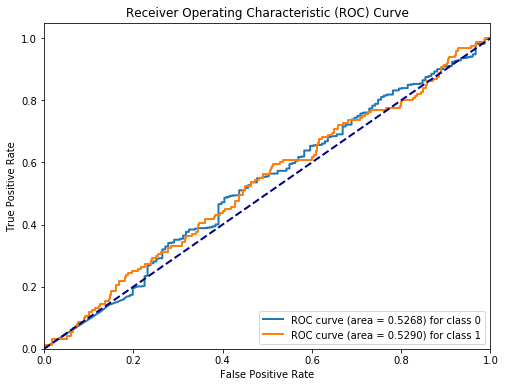

In [30]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.4f) for class %d' % (roc_auc[i], i))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()